In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
sys.path.insert(
    0, os.path.abspath(os.path.join(os.getcwd(), "../../DermSynth3D_private"))
)
from dermsynth3d.models.model import SkinDeepLabV3
from dermsynth3d.datasets.datasets import (
    Fitz17KAnnotations,
    ImageDataset,
    Ph2Dataset,
)
from dermsynth3d.utils.colorconstancy import shade_of_gray_cc
from dermsynth3d.models.inference import inference_multitask
from dermsynth3d.utils.evaluate import (
    compute_results,
    conf_mat_cells,
)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
model_name = "dataset960"
model_name = "may_18_2022_320x320_deeplab_paper"
model_name = "synth_221-m-u_indoor"
dir_models = "/mnt/d/models/image3d/"

In [23]:
# model_path = '/mnt/d/models/image3d/dataset3500'
# model_path = '/mnt/d/models/image3d/may_18_2022_320x320_deeplab_paper'
# model_path = '/mnt/d/models/image3d/dataset960'
# model_path = '/mnt/d/models/image3d/synth_221-m-u_indoor'
model_path = os.path.join(dir_models, model_name)

multitask_model = SkinDeepLabV3(multi_head=False, freeze_backbone=False)
multitask_model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [24]:
multitask_model = multitask_model.to(device)
multitask_model.eval();

In [25]:
img_size = (320, 320)

In [26]:
# Assumes the model was pretrained using these values.
preprocess_input = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
img_preprocess = A.Compose(
    [
        preprocess_input,
    ]
)

# To force a resize of the input image.
resize_func = A.Resize(
    height=img_size[0], width=img_size[1], interpolation=cv2.INTER_CUBIC
)
# Perform spatial augmentation on both the image and mask.
spatial_augment = A.Compose(
    [
        resize_func,
    ]
)
resize_aspect_smallest = A.augmentations.geometric.resize.SmallestMaxSize(
    max_size=img_size[0], always_apply=True
)

In [8]:
dir_wounds = "../../../wound-segmentation/data/Foot Ulcer Segmentation Challenge"
dir_wounds_train = os.path.join(dir_wounds, "validation")
dir_wounds_train_images = os.path.join(dir_wounds_train, "images")
dir_wounds_train_targets = os.path.join(dir_wounds_train, "labels")
dir_pred_wounds = "/mnt/d/predictions/wounds/deeplab_256_fivech4"
wound_ds = ImageDataset(
    dir_wounds_train_images,
    dir_wounds_train_targets,
    dir_predictions=dir_pred_wounds,
    image_extension=".png",
    target_extension=".png",
    spatial_transform=resize_aspect_smallest,
    image_augment=None,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
    color_constancy=shade_of_gray_cc,
)

In [9]:
wounds_dataloader = DataLoader(wound_ds, batch_size=1, shuffle=False)
len(wounds_dataloader)

200

In [10]:
def jaccard_index(pred, gt):
    intersection = np.sum(pred & gt)
    union = np.sum(pred | gt)

    if gt.sum() == 0:
        if pred.sum() == 0:
            return 1
        else:
            return 0
    return intersection / union

In [11]:
dir_skin_preds_wounds = "/mnt/d/data/wounds/valid/preds"
fitz_test = inference_multitask(
    max_imgs=len(wounds_dataloader),
    model=multitask_model,
    dataloader=wounds_dataloader,
    device=device,
    save_to_disk=True,
    return_values=True,
    dir_anatomy_preds="/mnt/d/data/wounds/valid/anatomy",
    dir_save_images="/mnt/d/data/wounds/valid/images",
    # dir_save_targets='/mnt/d/data/fitzpatrick17k/annotations/test/figs/targets',
    dir_save_skin_preds=dir_skin_preds_wounds,
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
wounds_df = pd.DataFrame(
    compute_results(wound_ds, dir_skin_preds_wounds, pred_ext=".png")
)
# Skin condition.
print(
    "{:.2f} \pm {:.2f}".format(
        wounds_df.lesion_ji.mean(),
        wounds_df.lesion_ji.std(),
    )
)

0.27 \pm 0.20


<h2>Fitzpatrick 17k test annotations</h2>

https://github.com/mattgroh/fitzpatrick17k

See instructions to download the images.

Update `dir_fitz_images` to the directory containing the fitzpatrick17k images.

Update `dir_fitz_test_annotations` to the subset of masks provided.

In [27]:
# Where the fitzpatrick images are stored.
dir_fitz_images = "/mnt/d/data/fitzpatrick17k/data/finalfitz17k"
# Where the manual annotations are stored.
dir_fitz_test_annotations = "/mnt/d/data/fitzpatrick17k/annotations/annotations-20220516T041017Z-001/annotations"
# dir_fitz_test_predictions = '/mnt/d/data/fitzpatrick17k/annotations/annotations-20220516T041017Z-001/figs/skin'
fitz_test_ds = Fitz17KAnnotations(
    dir_images=dir_fitz_images,
    dir_targets=dir_fitz_test_annotations,
    image_extension=".jpg",
    target_extension=".png",
    spatial_transform=resize_aspect_smallest,
    image_augment=None,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
    color_constancy=shade_of_gray_cc,
)
fitz_test_dataloader = DataLoader(fitz_test_ds, batch_size=1, shuffle=False)
len(fitz_test_dataloader)

25

In [28]:
def evaluate_directories(dir_root: str, model_name: str):
    paths = {}
    paths["prob_segs"] = os.path.join(dir_root, model_name, "prob_segs")
    paths["pred_segs"] = os.path.join(dir_root, model_name, "pred_segs")
    paths["pred_anatomy"] = os.path.join(dir_root, model_name, "pred_anatomy")
    paths["images"] = os.path.join(dir_root, model_name, "images")
    paths["targets"] = os.path.join(dir_root, model_name, "targets")

    for key in paths:
        if not os.path.isdir(paths[key]):
            os.makedirs(paths[key])

    return paths

In [29]:
dir_fitz_evaluate = "/mnt/d/data/fitzpatrick17k/evaluate"
fitz_paths = evaluate_directories(dir_root=dir_fitz_evaluate, model_name=model_name)

In [30]:
fitz_paths

{'prob_segs': '/mnt/d/data/fitzpatrick17k/evaluate/synth_221-m-u_indoor/prob_segs',
 'pred_segs': '/mnt/d/data/fitzpatrick17k/evaluate/synth_221-m-u_indoor/pred_segs',
 'pred_anatomy': '/mnt/d/data/fitzpatrick17k/evaluate/synth_221-m-u_indoor/pred_anatomy',
 'images': '/mnt/d/data/fitzpatrick17k/evaluate/synth_221-m-u_indoor/images',
 'targets': '/mnt/d/data/fitzpatrick17k/evaluate/synth_221-m-u_indoor/targets'}

In [31]:
fitz_test = inference_multitask(
    max_imgs=len(fitz_test_dataloader),
    model=multitask_model,
    dataloader=fitz_test_dataloader,
    device=device,
    save_to_disk=True,
    return_values=True,
    dir_anatomy_preds=fitz_paths["pred_anatomy"],
    dir_save_images=fitz_paths["images"],
    dir_save_targets=fitz_paths["targets"],
    dir_save_skin_preds=fitz_paths["pred_segs"],
    dir_save_skin_probs=fitz_paths["prob_segs"],
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [32]:
fitz_test_df = pd.DataFrame(
    compute_results(fitz_test_ds, fitz_paths["pred_segs"], pred_ext=".png")
)
# Skin condition.
print(
    "{:.2f} \pm {:.2f}".format(
        fitz_test_df.lesion_ji.mean(),
        fitz_test_df.lesion_ji.std(),
    )
)

# Skin.
print(
    "{:.2f} \pm {:.2f}".format(
        fitz_test_df.skin_ji.mean(),
        fitz_test_df.skin_ji.std(),
    )
)

# Nonskin.
print(
    "{:.2f} \pm {:.2f}".format(
        fitz_test_df.nonskin_ji.mean(),
        fitz_test_df.nonskin_ji.std(),
    )
)

0.51 \pm 0.26
0.79 \pm 0.17
0.52 \pm 0.42


In [33]:
def binary_conf_mat(pred, gt):
    tp = np.sum((pred == True) & (gt == True))
    fp = np.sum((pred == True) & (gt == False))
    tn = np.sum((pred == False) & (gt == False))
    fn = np.sum((pred == False) & (gt == True))

    return tp, fp, tn, fn

In [34]:
from multiprocessing.sharedctypes import Value
from dermsynth3d.utils.image import load_image
from dermsynth3d.utils.evaluate import argmax_predictions

ds = fitz_test_ds
dir_pred_probs = fitz_paths["prob_segs"]
lesion_res = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
skin_res = lesion_res.copy()
back_res = lesion_res.copy()


for image_id in ds.file_ids:
    gt = np.asarray(ds.target(image_id)).astype(bool)
    prob_filename = os.path.join(dir_pred_probs, image_id + ".png")
    pred = np.asarray(load_image(prob_filename))
    # pred_seg = np.asarray(ds.prediction(image_id))
    pred = argmax_predictions(pred)

    for idx in range(3):
        tp, fp, tn, fn = binary_conf_mat(pred[:, :, idx], gt[:, :, idx])
        if idx == 0:
            res = lesion_res
        elif idx == 1:
            res = skin_res
        elif idx == 2:
            res = back_res
        else:
            raise ValueError("Error: outside of expected range")

        res["tp"] += tp
        res["fp"] += fp
        res["tn"] += tn
        res["fn"] += fn

In [35]:
# Single mesh model.
for res in [lesion_res, skin_res, back_res]:
    print("{:.2f} ".format(res["tp"] / (res["tp"] + res["fp"] + res["fn"])))

0.48 
0.83 
0.87 


In [114]:
# 960 model.
for res in [lesion_res, skin_res, back_res]:
    print("{:.2f} ".format(res["tp"] / (res["tp"] + res["fp"] + res["fn"])))

0.57 
0.88 
0.86 


In [17]:
# Full paper model
for res in [lesion_res, skin_res, back_res]:
    print("{:.2f} ".format(res["tp"] / (res["tp"] + res["fp"] + res["fn"])))

0.55 
0.89 
0.89 


In [94]:
tp / (tp + fp + fn)

0.7803022936721442

In [95]:
np.sum(pred[:, :, idx] & gt[:, :, idx]) / np.sum(pred[:, :, idx] | gt[:, :, idx])

0.7803022936721442

In [32]:
pred_seg.dtype

dtype('bool')

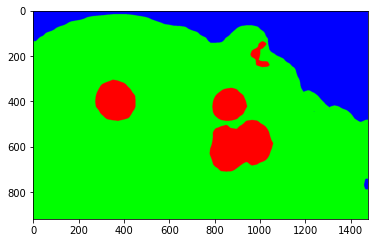

In [34]:
plt.imshow(pred_seg * 255)

<h2>PH2 results</h2>

https://www.fc.up.pt/addi/ph2%20database.html

Update `dir_images` to your path to the images.

In [16]:
resize_aspect_longest = A.augmentations.geometric.resize.LongestMaxSize(
    max_size=img_size[0], always_apply=True
)

ph2_img_augment = A.Compose(
    [
        A.GaussianBlur(blur_limit=(9, 9), always_apply=True),
    ]
)

ph2_ds = Ph2Dataset(
    dir_images="/mnt/d/data/PH2Dataset/PH2Dataset/PH2 Dataset images",
    dir_targets="/mnt/d/data/PH2Dataset/PH2Dataset/PH2 Dataset images",
    name="ph2",
    image_extension=".bmp",
    target_extension=".bmp",
    image_augment=ph2_img_augment,
    spatial_transform=resize_aspect_longest,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
    color_constancy=shade_of_gray_cc,
)
print(len(ph2_ds))
ph2_dataloader = DataLoader(ph2_ds, batch_size=1, shuffle=False)

200


In [17]:
dir_skin_preds_ph2_test = "/mnt/d/predictions/ph2/figs/skin"
ph2_preds = inference_multitask(
    max_imgs=len(ph2_dataloader),
    model=multitask_model,
    dataloader=ph2_dataloader,
    device=device,
    save_to_disk=True,
    return_values=False,
    dir_save_images="/mnt/d/predictions/ph2/figs/images",
    dir_save_targets="/mnt/d/predictions/ph2/figs/targets",
    dir_save_skin_preds=dir_skin_preds_ph2_test,
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
ph2_test_df = pd.DataFrame(
    compute_results(ph2_ds, dir_skin_preds_ph2_test, pred_ext=".bmp")
)
# Skin condition.
print(
    "{:.2f} \pm {:.2f}".format(
        ph2_test_df.lesion_ji.mean(),
        ph2_test_df.lesion_ji.std(),
    )
)

0.56 \pm 0.20


<h2>Dermofit results</h2>

https://licensing.edinburgh-innovations.ed.ac.uk/product/dermofit-image-library

Requires a license and a fee.

Update `dir_images` and `dir_targets` to your paths.

In [19]:
dermofit_img_augment = A.Compose(
    [
        A.GaussianBlur(blur_limit=(3, 3), always_apply=True),
    ]
)
dermofit_ds = ImageDataset(
    dir_images="/mnt/d/data/DermoFit_Segmentation/images",
    dir_targets="/mnt/d/data/DermoFit_Segmentation/targets",
    # dir_predictions='/mnt/d/data/DermoFit_Segmentation/predictions',
    name="dermofit",
    image_extension=".png",
    target_extension=".png",
    image_augment=None,  # dermofit_img_augment,#dermofit_img_augment,
    spatial_transform=resize_aspect_smallest,  # resize_aspect_longest, #resize_aspect_smallest, #spatial_augment,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
    color_constancy=shade_of_gray_cc,
)
print(len(dermofit_ds))
dermofit_dataloader = DataLoader(dermofit_ds, batch_size=1, shuffle=False)

1300


In [20]:
dir_skin_preds_dermofit = "/mnt/d/data/DermoFit_Segmentation/predictions"
dermofit_preds = inference_multitask(
    max_imgs=len(dermofit_dataloader),
    model=multitask_model,
    dataloader=dermofit_dataloader,
    device=device,
    save_to_disk=True,
    return_values=False,
    dir_save_skin_preds=dir_skin_preds_dermofit,
)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [21]:
dermofit_df = pd.DataFrame(
    compute_results(dermofit_ds, dir_skin_preds_dermofit, pred_ext=".png")
)
# Skin condition.
print(
    "{:.2f} \pm {:.2f}".format(
        dermofit_df.lesion_ji.mean(),
        dermofit_df.lesion_ji.std(),
    )
)

0.58 \pm 0.22


<h2>Pratheepan results on FacePhoto</h2>

Data from:
https://web.fsktm.um.edu.my/~cschan/downloads_skin_dataset.html

Update `dir_images` and `dir_targets` to your data paths to the images and skin masks.

In [22]:
pratheepan_ds = ImageDataset(
    dir_images="/mnt/d/data/Face_Dataset/Pratheepan_Dataset/FacePhoto",
    dir_targets="/mnt/d/data/Face_Dataset/Ground_Truth/GroundT_FacePhoto",
    name="pratheepan",
    image_extension=".jpg",
    target_extension=".png",
    image_augment=None,
    spatial_transform=resize_aspect_smallest,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
    color_constancy=shade_of_gray_cc,
)

In [23]:
dir_skin_preds_pratheepan = (
    "/mnt/d/data/Face_Dataset/Pratheepan_Dataset/predictions/FacePhoto/skin"
)
pratheepan_dataloader = DataLoader(pratheepan_ds, batch_size=1, shuffle=False)
pratheepan_preds = inference_multitask(
    max_imgs=len(pratheepan_ds),
    model=multitask_model,
    dataloader=pratheepan_dataloader,
    device=device,
    save_to_disk=True,
    return_values=False,
    dir_anatomy_preds="/mnt/d/data/Face_Dataset/Pratheepan_Dataset/predictions/FacePhoto/anatomy",
    dir_save_skin_preds=dir_skin_preds_pratheepan,
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [24]:
pratheepan_df = pd.DataFrame(
    compute_results(pratheepan_ds, dir_skin_preds_pratheepan, pred_ext=".png")
)
# Skin condition.
print(
    "{:.2f} \pm {:.2f}".format(
        pratheepan_df.skin_ji.mean(),
        pratheepan_df.skin_ji.std(),
    )
)

0.77 \pm 0.14


In [27]:
res = conf_mat_cells(pratheepan_ds, dir_skin_preds_pratheepan, ".png")
tps = res["tps"]
fps = res["fps"]
fns = res["fns"]

In [28]:
f1 = (2 * np.sum(tps)) / ((2 * np.sum(tps)) + np.sum(fps) + np.sum(fns))
f1

0.8578159369564877

In [ ]:
`   `